# Assignment 2
## Question 1: Siamese networks & one-shot learning (7pt)
The Cifar-100 dataset is similar to the Cifar-10 dataset. It also consists of 60,000 32x32 RGB images, but they are distributed over 100 classes instead of 10. Thus, each class has much fewer examples, only 500 training images and 100 testing images per class. For more info about the dataset, see https://www.cs.toronto.edu/~kriz/cifar.html.

*HINT: Import the Cifar-100 dataset directly from Keras, no need to download it from the website. Use* `label_mode="fine"`

### Task 1.1: Siamese network
**a)**
* Train a Siamese Network on the first 80 classes of (the training set of) Cifar-100, i.e. let the network predict the probability that two input images are from the same class. Use 1 as a target for pairs of images from the same class (positive pairs), and 0 for pairs of images from different classes (negative pairs). Randomly select image pairs from Cifar-100, but make sure you train on as many positive pairs as negative pairs.

* Evaluate the performance of the network on 20-way one-shot learning tasks. Do this by generating 250 random tasks and obtain the average accuracy for each evaluation round. Use the remaining 20 classes that were not used for training. The model should perform better than random guessing.

For this question you may ignore the test set of Cifar-100; it suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

*HINT: First sort the data by their labels (see e.g.* `numpy.argsort()`*), then reshape the data to a shape of* `(n_classes, n_examples, width, height, depth)`*, similar to the Omniglot data in Practical 4. It is then easier to split the data by class, and to sample positive and negative images pairs for training the Siamese network.*

*NOTE: do not expect the one-shot accuracy for Cifar-100 to be similar to that accuracy for Omniglot; a lower accuracy can be expected. However, accuracy higher than random guess is certainly achievable.*

In [2]:
import matplotlib.pyplot as plt
from keras.datasets import cifar100
import numpy as np
import pandas as pd
import os
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from sklearn.utils import shuffle

Using TensorFlow backend.


In [5]:
# === add code here ===
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode="fine")

169009152/169001437 [==============================] - 20s 0us/step


In [6]:
print(x_train.shape)

(50000, 32, 32, 3)


In [7]:
y_train = y_train.flatten()
y_test = y_test.flatten()
print(y_train.shape)
print(y_test.shape)

(50000,)
(10000,)


In [0]:
class_labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm']

Class label: skunk


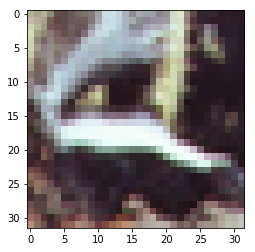

In [9]:
example_id = 39999  # pick any integer from 0 to 49999 to visualize a training example
example = x_train[example_id]
label = y_train[example_id]
print("Class label:", class_labels[label])
plt.imshow(example)
plt.show()

In [10]:
img_rows,img_cols,chns = 32, 32, 3
n_classes = 100

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
input_shape = (img_rows, img_cols, chns)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [11]:
indexes = y_train.argsort()
print(indexes)

[42957  2126 43210 ... 42095 26322 21122]


(50000, 32, 32, 3)
(50000,)
Class label: spider


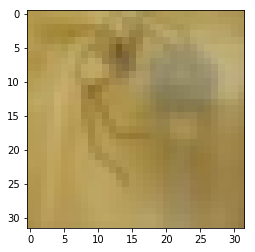

In [12]:
x_train_sort = x_train[indexes]
y_train_sort = y_train[indexes]

print(x_train_sort.shape)
print(y_train_sort.shape)

example_id = 39999  # pick any integer from 0 to 49999 to visualize a training example
example = x_train_sort[example_id]
label = y_train_sort[example_id]
print("Class label:", class_labels[label])
plt.imshow(example)
plt.show()

In [0]:
def group(a, b):
    # Get argsort indices, to be used to sort a and b in the next steps
    sidx = b.argsort(kind='mergesort')
    a_sorted = a[sidx]
    b_sorted = b[sidx]

    # Get the group limit indices (start, stop of groups)
    cut_idx = np.flatnonzero(np.r_[True,b_sorted[1:] != b_sorted[:-1],True])

    # Create cut indices for all unique IDs in b
    n = b_sorted[-1]+2
    cut_idxe = np.full(n, cut_idx[-1], dtype=int)

    insert_idx = b_sorted[cut_idx[:-1]]
    cut_idxe[insert_idx] = cut_idx[:-1]
    cut_idxe = np.minimum.accumulate(cut_idxe[::-1])[::-1]

    # Split input array with those start, stop ones
    out = [a_sorted[i:j] for i,j in zip(cut_idxe[:-1],cut_idxe[1:])]
    return np.array(out)

In [14]:
x_train_shape = group(x_train_sort, y_train_sort)
x_test_shape = group(x_test, y_test)
x_test.shape

(10000, 32, 32, 3)

In [15]:
print(len(x_train_shape))
x_train_samples = x_train_shape[:80]
y_train_samples = y_train_sort[:80]
print(len(x_train_samples))
print(x_train_samples.shape)
print(y_train_samples.shape)
print(x_test_shape.shape)

100
80
(80, 500, 32, 32, 3)
(80,)
(100, 100, 32, 32, 3)


In [16]:
input_shape = (32, 32, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

# build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
#convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(256, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(Flatten())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3)))
convnet.summary()

# encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# merge two encoded inputs with the L1 distance between them, and connect to prediction output layer
L1_distance = lambda x: K.abs(x[0]-x[1])
both = Lambda(L1_distance)([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(both)
siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)


siamese_net.compile(loss="binary_crossentropy", optimizer="adam")

siamese_net.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxP

In [0]:
def get_batch(batch_size, X):
    """Create batch of n pairs, half same class, half different class"""
    n_classes, n_examples, w, h, d = X.shape
    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)
    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, d)) for i in range(2)]
    # initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = np.random.randint(0, n_examples)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(w, h, d)
        idx_2 = np.random.randint(0, n_examples)
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category
        else:
            #add a random number to the category modulo n_classes to ensure 2nd image has different category
            category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        pairs[1][i, :, :, :] = X[category_2,idx_2].reshape(w, h, d)
    return pairs, targets

def batch_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, X)
        yield (pairs, targets)

def train(model, X_train, batch_size=64, steps_per_epoch=100, epochs=10):
    model.fit_generator(batch_generator(batch_size, X_train), steps_per_epoch=steps_per_epoch, epochs=epochs)

In [18]:
train(siamese_net, x_train_samples)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
100/100 [==============================] - 11s 113ms/step - loss: 1.8693
Epoch 2/10
100/100 [==============================] - 5s 54ms/step - loss: 1.2813
Epoch 3/10
100/100 [==============================] - 5s 54ms/step - loss: 0.9959
Epoch 4/10
100/100 [==============================] - 5s 54ms/step - loss: 0.8697
Epoch 5/10
100/100 [==============================] - 5s 54ms/step - loss: 0.8064
Epoch 6/10
100/100 [==============================] - 5s 54ms/step - loss: 0.7759
Epoch 7/10
100/100 [==============================] - 5s 55ms/step - loss: 0.7641
Epoch 8/10
100/100 [==============================] - 5s 55ms/step - loss: 0.7550
Epoch 9/10
100/100 [==============================] - 5s 55ms/step - loss: 0.7420
Epoch 10/10
100/100 [==============================] - 5s 55ms/step - loss: 0.7283


In [0]:
def make_oneshot_task(N, X, c, language=None):
    """Create pairs of (test image, support set image) with ground truth, for testing N-way one-shot learning."""
    n_classes, n_examples, w, h, d = X.shape
    indices = np.random.randint(0, n_examples, size=(N,))
    if language is not None:
        low, high = c[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = np.random.choice(range(low,high), size=(N,), replace=False)
    else:  # if no language specified just pick a bunch of random letters
        categories = np.random.choice(range(n_classes), size=(N,), replace=False)            
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, d)
    support_set = X[categories, indices, :, :]
    support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, d)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]
    return pairs, targets

def test_oneshot(model, X, c, N=20, k=250, language=None, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N, X, c, language=language)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning".format(percent_correct, N))
    return percent_correct

In [0]:
pairs, targets = make_oneshot_task(20, x_train_samples, y_train_samples)
#plot_oneshot_task(pairs)

In [21]:
best_acc = 0
train(siamese_net, x_train_samples)
test_acc = test_oneshot(siamese_net, x_test_shape, y_test)
if test_acc >= best_acc:
    print("New best one-shot accuracy, saving model ...")
    siamese_net.save(os.path.join("models", "siamese_omniglot.h5"))
    best_acc = test_acc

Epoch 1/10
100/100 [==============================] - 6s 60ms/step - loss: 0.7269
Epoch 2/10
100/100 [==============================] - 5s 54ms/step - loss: 0.7223
Epoch 3/10
100/100 [==============================] - 5s 55ms/step - loss: 0.7163
Epoch 4/10
100/100 [==============================] - 5s 55ms/step - loss: 0.7130
Epoch 5/10
100/100 [==============================] - 5s 54ms/step - loss: 0.7091
Epoch 6/10
100/100 [==============================] - 5s 54ms/step - loss: 0.7114
Epoch 7/10
100/100 [==============================] - 5s 54ms/step - loss: 0.7039
Epoch 8/10
100/100 [==============================] - 5s 54ms/step - loss: 0.7048
Epoch 9/10
100/100 [==============================] - 5s 54ms/step - loss: 0.7043
Epoch 10/10
100/100 [==============================] - 5s 54ms/step - loss: 0.7064
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13.6% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...


OSError: ignored

***

**b)** Compare the performance of your Siamese network for Cifar-100 to the Siamese network from Practical 4 for Omniglot. Name three fundamental differences between the Cifar-100 and Omniglot datasets. How do these differences influence the difference in one-shot accuracy?

**Answer:**

*=== write your answer here ===*

***

### Task 1.2: One-shot learning with neural codes
**a)**
* Train a CNN classifier on the first 80 classes of Cifar-100. Make sure it achieves at least 40% classification accuracy on those 80 classes (use the test set to validate this accuracy).
* Then use neural codes from one of the later hidden layers of the CNN with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100 with 250 random tasks. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.

(40000, 32, 32, 3)
(40000, 100)
(10000, 100)
Class label: spider


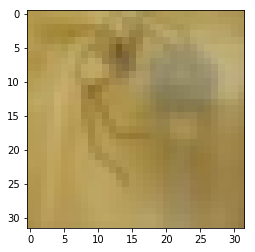

In [22]:
x_training_CNN = x_train_sort[:40000]
y_training = y_train_sort[:40000]

y_training_CNN = to_categorical(y_training, 100)
y_test_CNN = to_categorical(y_test, 100)

print(x_training_CNN.shape)
print(y_training_CNN.shape)
print(y_test_CNN.shape)

example_id = 39999  # pick any integer from 0 to 49999 to visualize a training example
example = x_training_CNN[example_id]
label = y_train_sort[example_id]
print("Class label:", class_labels[label])
plt.imshow(example)
plt.show()

In [62]:
# === add code here ===
input_shape = (32, 32, 3)
model = Sequential()
model.add(Conv2D(32,(3,3),activation = 'relu', input_shape = input_shape))
#model.add(Conv2D(32,(3,3),activation = 'relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(64,(3,3),activation = 'relu'))
#model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
#model.add(Conv2D(256,(3,3),activation = 'relu'))
#model.add(Conv2D(128,(3,3),activation = 'relu'))
#model.add(MaxPooling2D())
#model.add(BatchNormalization())
#model.add(Dropout(0.4))
model.add(Flatten())
#model.add(Conv2D(256,(3,3),activation = 'relu'))
#model.add(Conv2D(256,(3,3),activation = 'relu'))
#model.add(MaxPooling2D())
#model.add(BatchNormalization())
#model.add(Dropout(0.25))
model.add(Dense(100,activation = 'softmax'))

model.summary()

model.compile(optimizer="adadelta", loss="categorical_crossentropy", metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 15, 15, 32)        128       
_________________________________________________________________
dropout_38 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 6, 6, 64)          256       
__________

In [65]:
batch_size = 100
epochs = 10
print(x_training_CNN.shape)
print(y_training_CNN.shape)
model.fit(x_training_CNN, y_training_CNN,
          batch_size=batch_size,
          epochs=epochs,
          validation_data = (x_test, y_test_CNN))

(40000, 32, 32, 3)
(40000, 100)
Train on 36000 samples, validate on 4000 samples
Epoch 1/10
36000/36000 [==============================] - 6s 161us/step - loss: 2.0823 - acc: 0.4521 - val_loss: 7.2763 - val_acc: 0.0015
Epoch 2/10
36000/36000 [==============================] - 6s 159us/step - loss: 2.0387 - acc: 0.4620 - val_loss: 8.7795 - val_acc: 2.5000e-04
Epoch 3/10
36000/36000 [==============================] - 6s 159us/step - loss: 2.0179 - acc: 0.4666 - val_loss: 9.9769 - val_acc: 0.0000e+00
Epoch 4/10
36000/36000 [==============================] - 6s 159us/step - loss: 1.9966 - acc: 0.4685 - val_loss: 11.0055 - val_acc: 0.0000e+00
Epoch 5/10
36000/36000 [==============================] - 6s 158us/step - loss: 1.9804 - acc: 0.4760 - val_loss: 12.2723 - val_acc: 0.0000e+00
Epoch 6/10
36000/36000 [==============================] - 6s 157us/step - loss: 1.9539 - acc: 0.4767 - val_loss: 9.8306 - val_acc: 5.0000e-04
Epoch 7/10
36000/36000 [==============================] - 6s 156us/st

In [66]:
loss, accuracy = model.evaluate(x_test, y_test_CNN, verbose=1)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

10000/10000 [==============================] - 1s 123us/step
Test loss: 6.1813901512145994
Test accuracy: 0.2505


***

**b)** Briefly motivate your CNN architecture, and discuss the difference in one-shot accuracy between the Siamese network approach and the CNN neural codes approach.

**Answer:**

*=== write your answer here ===*

***
## Question 2: Triplet networks & one-shot learning (10pt)

### Task 2.1: Train a triplet network
**a)**
* Train a triplet network on the first 80 classes of (the training set of) Cifar-100.
 
* Make sure the network achieves a smaller loss than the margin and the network does not collapse all representations to zero vectors. *HINT: If you experience problems to achieve this goal, it might be helpful to tinker the learning rate.*

* You are provided with a working example of triplet loss implementation for Keras below. You may directly use it.

You may ignore the test set of Cifar-100 for this question as well. It suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

```python
# Notice that ground truth variable is not used for loss calculation. It is used as a function argument to by-pass some Keras functionality. This is because the network structure already implies the ground truth for the anchor image with the "positive" image.
import tensorflow as tf
def triplet_loss(ground_truth, network_output):

    anchor, positive, negative = tf.split(network_output, num_or_size_splits=3, axis=1)        
    
    for embedding in [anchor, positive, negative]:
        embedding = tf.math.l2_normalize(embedding)

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=1)
    
    margin = # define your margin
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), margin)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), axis=0)

    return loss
```


In [0]:
# === add code here ===

***

### Task 2.2: One-shot learning with triplet neural codes
**a)**
* Use neural codes from the triplet network with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100 with 250 random tasks. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.
* Explicitly state the accuracy.

In [0]:
# === add code here ===

***
## Question 3: Performance comparison (3pt)


**a)** What accuracy would random guessing achieve (on average) on this dataset? Motivate your answer briefly.

*=== write your answer here ===*



**b)** Discuss and compare the performances of networks in tasks 1.1, 1.2 and 2.2. Briefly motivate and explain which task would be expected the highest accuracy. Explain the reasons of the accuracy difference if there are any. If there is almost no difference accuracy, explain the reason for that.

*=== write your answer here ===*

***
## Question 4: Peer review (0pt)

Finally, each group member must write a single paragraph outlining their opinion on the work distribution within the group. Did every group member contribute equally? Did you split up tasks in a fair manner, or jointly worked through the exercises. Do you think that some members of your group deserve a different grade from others?

*=== write your answer here ===*